In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['legend.fontsize'] = 30

import seaborn as sns
sns.set_style('whitegrid')

import json
import os

In [9]:
#dataPath = os.path.join('/Users/xliu/Documents/MRC/Work/Program/BayesianModelling/',
#                       'Bayesian-Modelling-in-Python-master/data/')

dataFile = 'hangout_chat_data.csv'

In [10]:
#dataOG = pd.read_csv(dataPath + dataFile)
dataOG = pd.read_csv(dataFile)
data = dataOG.copy()

In [11]:
data.shape

(338, 14)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338 entries, 0 to 337
Data columns (total 14 columns):
conversation_id       338 non-null object
event_id              338 non-null object
timestamp             338 non-null object
sender                338 non-null object
message_length        338 non-null int64
num_participants      338 non-null int64
message_type          338 non-null object
prev_timestamp        338 non-null object
prev_sender           338 non-null object
time_delay_seconds    338 non-null float64
time_delay_mins       338 non-null float64
day_of_week           338 non-null int64
year_month            338 non-null object
is_weekend            338 non-null int64
dtypes: float64(2), int64(4), object(8)
memory usage: 37.0+ KB


In [13]:
data.describe()

,message_length,num_participants,time_delay_seconds,time_delay_mins,day_of_week,is_weekend
count,338.000000,338.000000,338.000000,338.000000,338.000000,338.000000
mean,32.946746,2.153846,18.230769,0.979290,2.304734,0.097633
std,31.502863,0.511006,13.904720,0.142623,1.664441,0.297258
min,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,10.000000,2.000000,8.000000,1.000000,1.000000,0.000000
50%,24.000000,2.000000,14.000000,1.000000,2.000000,0.000000
75%,45.000000,2.000000,25.750000,1.000000,3.000000,0.000000
max,198.000000,4.000000,58.000000,1.000000,6.000000,1.000000


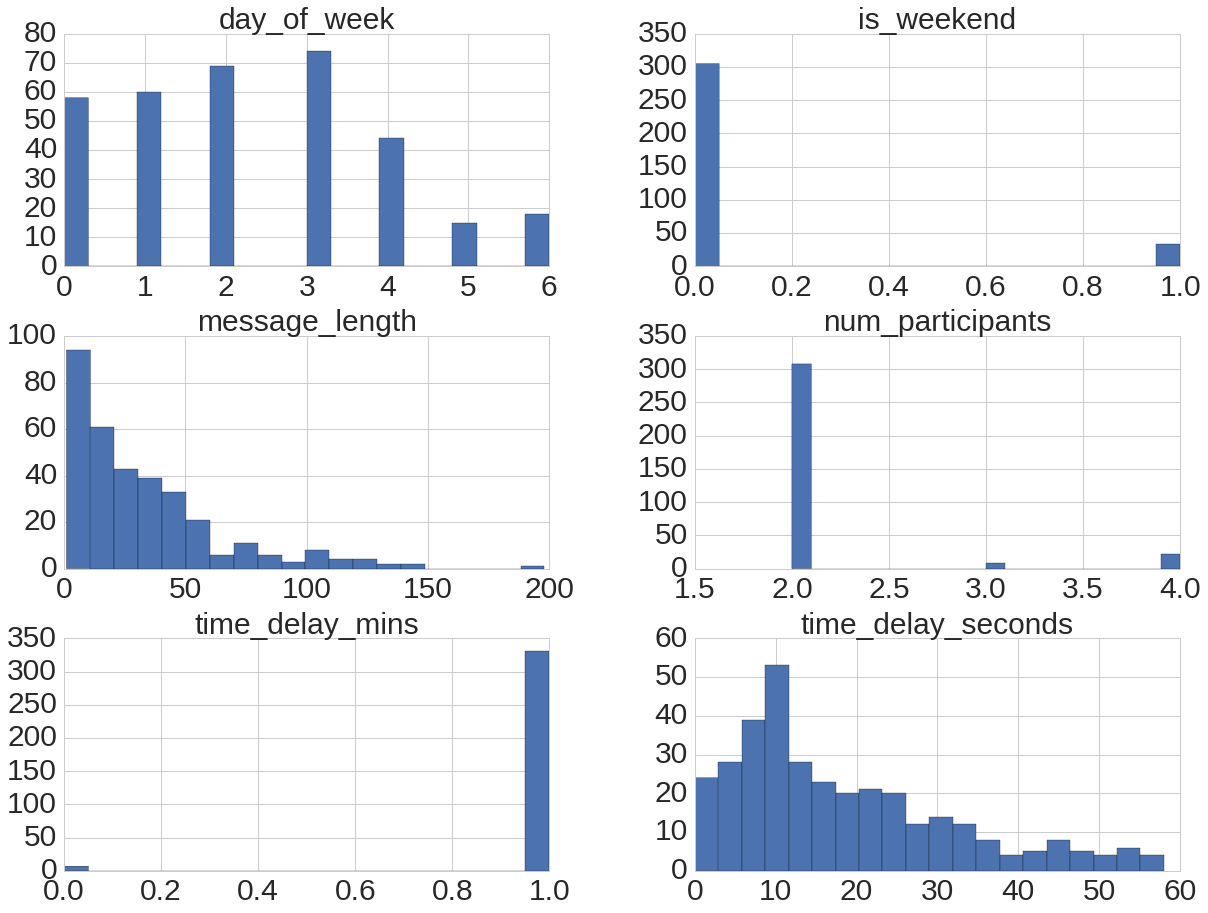

In [14]:
data.hist(bins=20, figsize=(20,15));

In [15]:
data.head(2)

,conversation_id,event_id,timestamp,sender,message_length,num_participants,message_type,prev_timestamp,prev_sender,time_delay_seconds,time_delay_mins,day_of_week,year_month,is_weekend
0,Ugw5Xrm3ZO5mzAfKB7V4AaABAQ,7-H0Z7-FkyB7-HDBYj4KKh,2014-08-15 03:44:12.840015,Mark Regan,14,3,TEXT,2014-08-15 03:44:00.781653,Keir Alexander,12.0,1.0,4,2014-08,0
1,UgwLUkm5oqPrUyjqFlR4AaABAQ,85SWvmXIEV285Sb1E65xL0,2015-10-18 09:36:39.438706,Mark Regan,47,4,TEXT,2015-10-18 09:36:10.932367,Louise Regan,28.0,1.0,6,2015-10,1


### response time

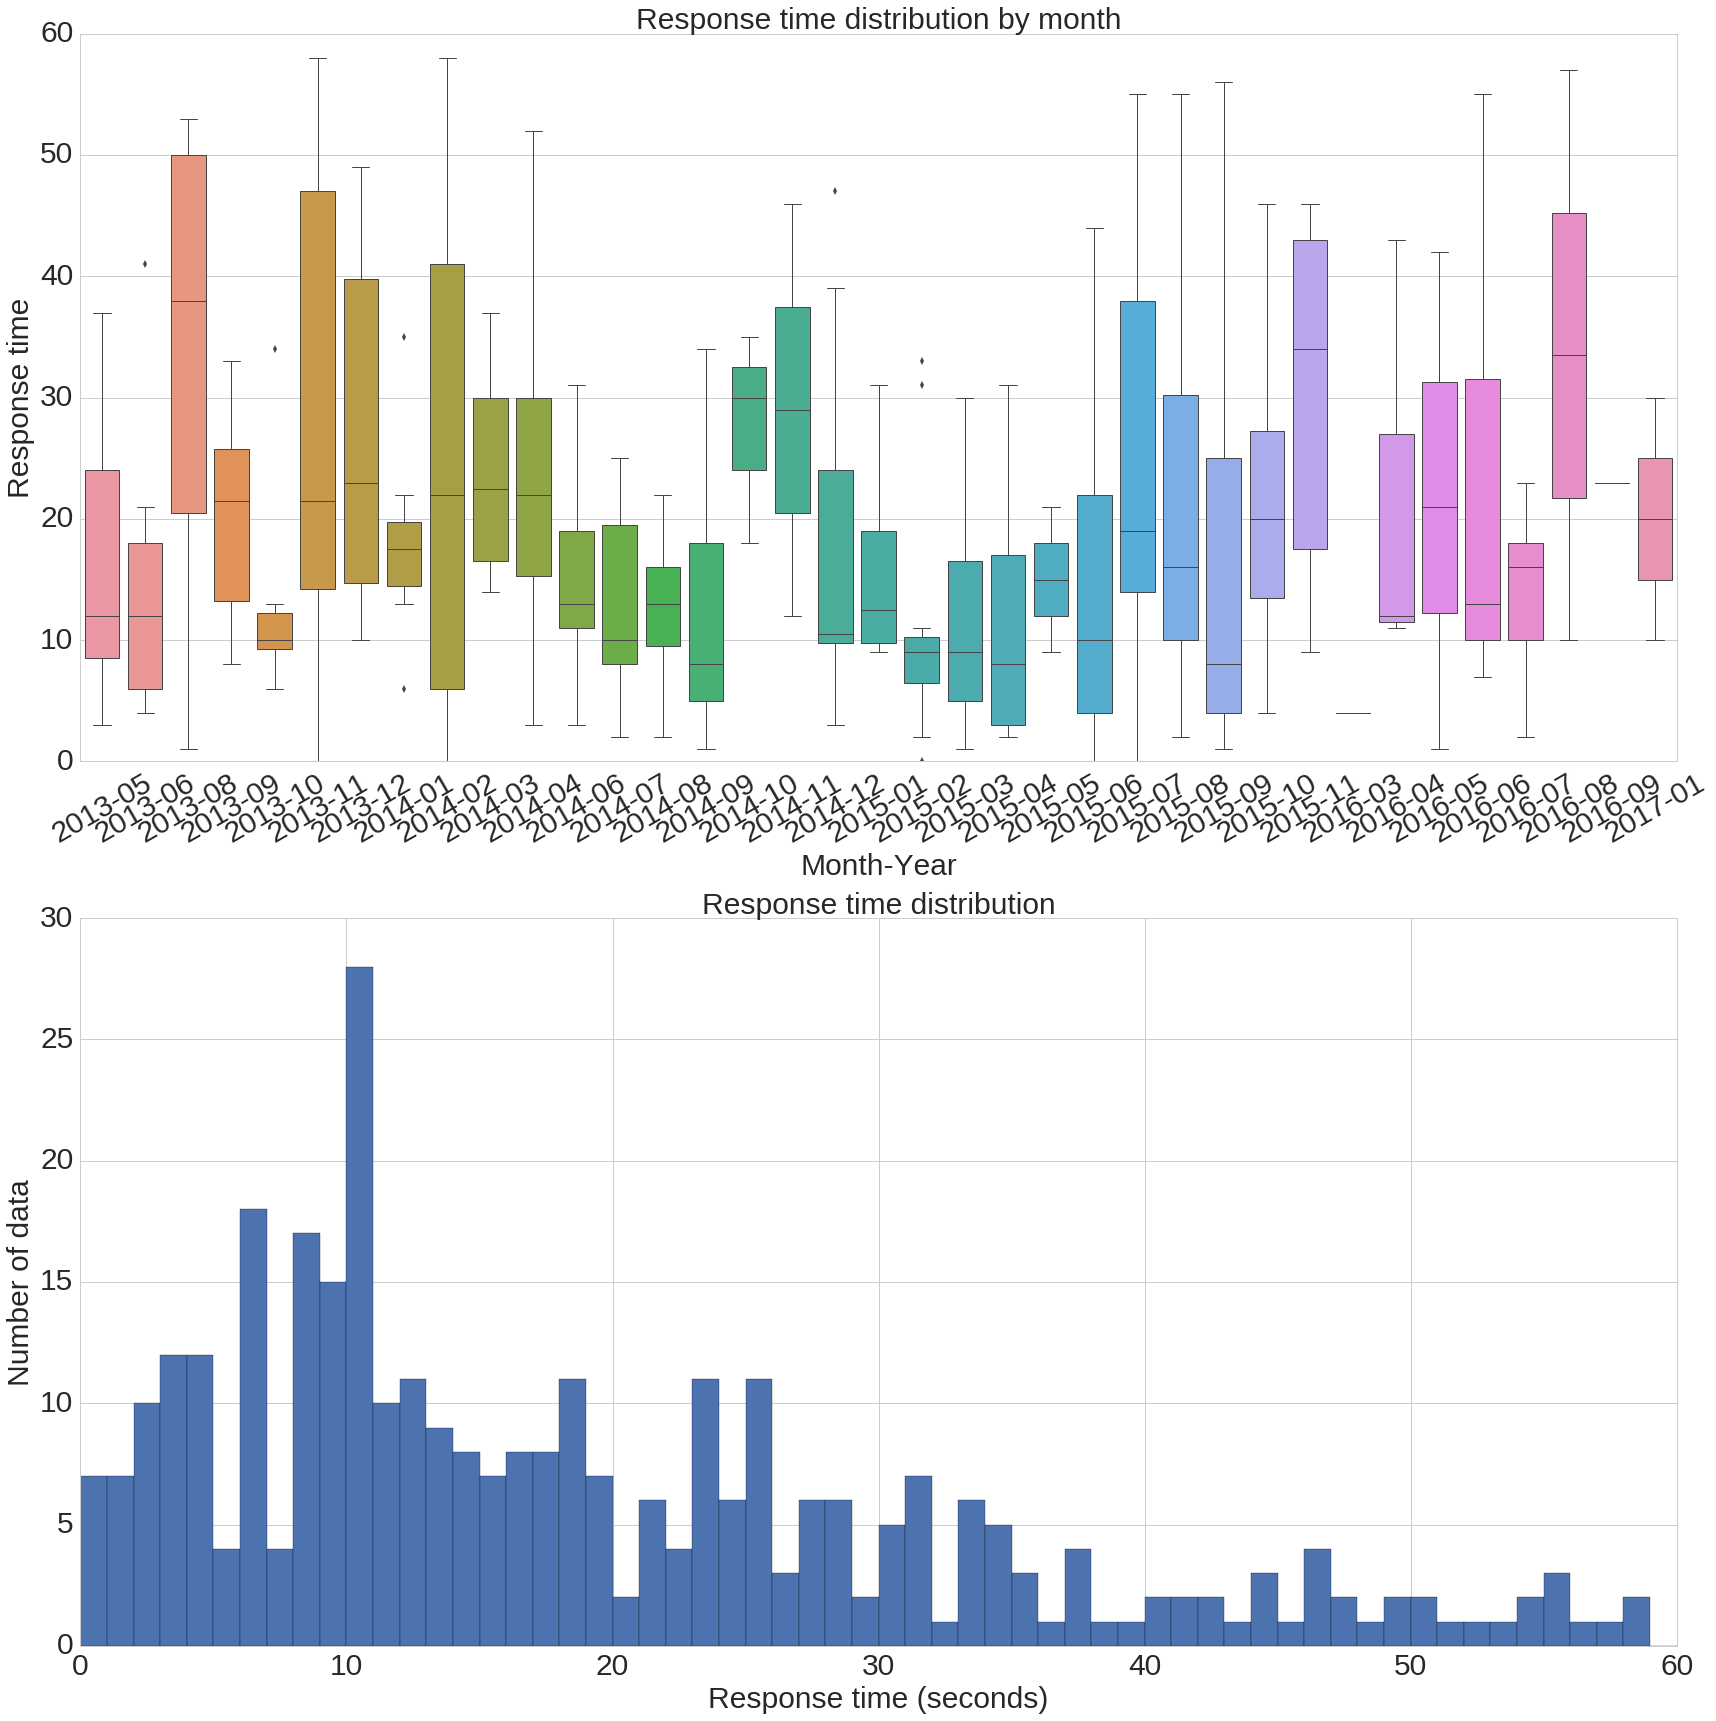

In [16]:
fig = plt.figure(figsize=(24,24))
ax1  = plt.subplot(211)

order = np.sort(data['year_month'].unique())
sns.boxplot(x=data['year_month'], y=data['time_delay_seconds'],order=order, orient='v', linewidth=1, ax=ax1)
_ = ax1.set_title('Response time distribution by month')
_ = ax1.set_xlabel('Month-Year')
_ = ax1.set_ylabel('Response time')
_ = plt.xticks(rotation=30)

ax2 = plt.subplot(212)
plt.hist(data['time_delay_seconds'].values, range=[0, 60], bins = 60)
_ = ax2.set_title('Response time distribution')
_ = ax2.set_xlabel('Response time (seconds)')
_ = ax2.set_ylabel('Number of data')

plt.tight_layout()

# Section 2. Estimating model parameters

In [17]:
import pymc3 as pm
import scipy
import scipy.stats as stats
import scipy.optimize as opt
import statsmodels.api as sm

## three Poisson distributions with three mean/variance

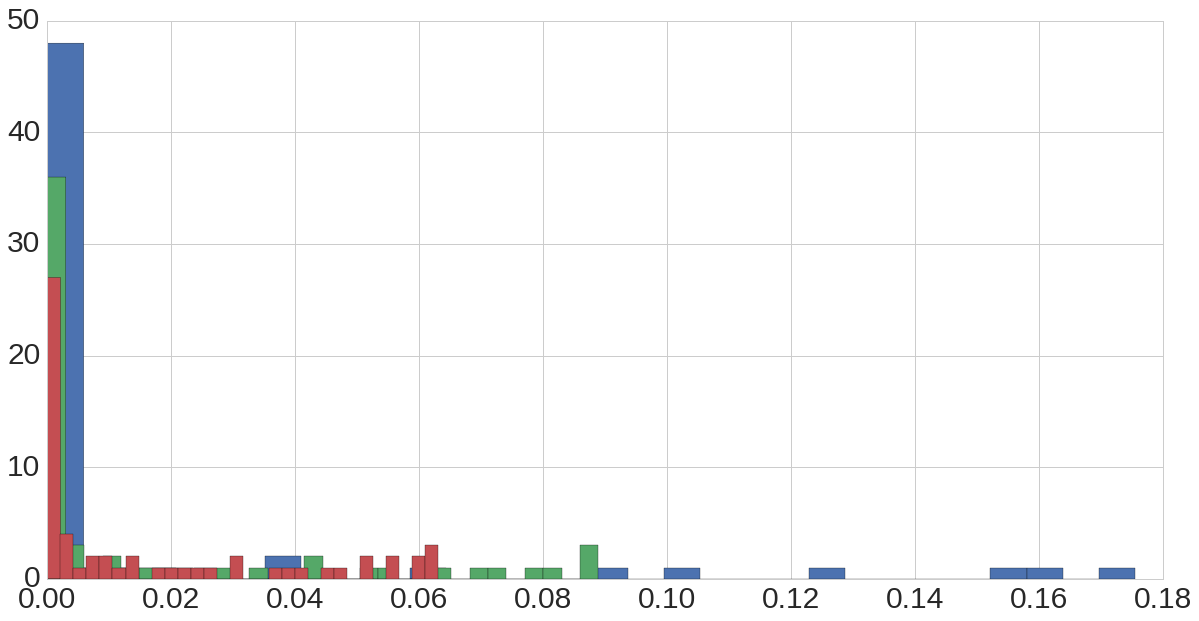

In [18]:
plt.figure(figsize=(20,10))
x     = range(60)
mu    = [5, 20, 40]

poi_dis_1 = stats.poisson.pmf(mu[0], x)
poi_dis_2 = stats.poisson.pmf(mu[1], x)
poi_dis_3 = stats.poisson.pmf(mu[2], x)

plt.hist(poi_dis_1, bins=30);
plt.hist(poi_dis_2, bins=30);
plt.hist(poi_dis_3, bins=30);

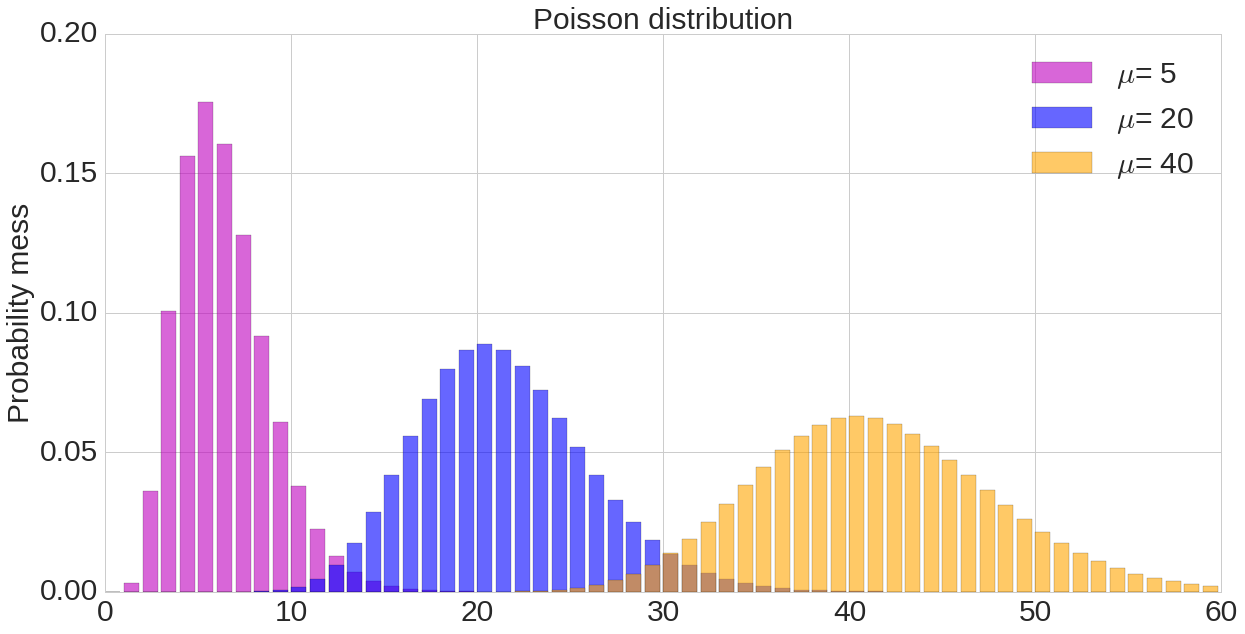

In [19]:
plt.figure(figsize=(20,10))
ax = plt.subplot(111)
for n in range(60):
    plt.bar(n, stats.poisson.pmf(mu[0], n), color = 'm', alpha=0.6)
    plt.bar(n, stats.poisson.pmf(mu[1], n), color = 'b', alpha=0.6)
    plt.bar(n, stats.poisson.pmf(mu[2], n), color = 'orange', alpha=0.6)

ax.set_xlim(0, 60)
ax.set_ylim(0, 0.2)
ax.set_ylabel('Probability mess')
ax.set_title('Poisson distribution')
plt.legend(['$\mu$= %s' % mu[0],'$\mu$= %s' % mu[1],'$\mu$= %s' % mu[2]]);

## Frequentists method of estimating the $\mu$ of response time

Given that response_time is count data, we can model it as a Poisson distribution and estimate its parameter $\mu$. We will explore both a frequentist and Bayesian method of estimating this parameter.

First look at a frequentist method of estimating the parameters of a Poisson distribution. It is able to use an optimization technique that aims to maximize the likelihood of a function.
The below function poisson_logprob() returns the overall likelihood of the observed data given a Poisson model and parameter value. We use the method opt.minimize_scalar to find the value of $\mu$ that is most credible (maximizes the log likelihood) given the data observed. Under the hood, this optimization technique is intelligently iterating through possible values of mu until it finds a value with the highest likelihood.

In [20]:
yobs = data['time_delay_seconds'].values

In [21]:
# negative log-Poisson
def poisson_logprob(y, mu, sign=-1):
    poi_log_pmf = stats.poisson.logpmf(y, mu)
    poi_logprob = np.sum(sign * poi_log_pmf)
    return poi_logprob

In [22]:
poi_loglik = lambda mu: poisson_logprob(yobs, mu)

In [23]:
freq_results = opt.minimize_scalar(poi_loglik)

In [24]:
%time print('The estimated value of mu is: %s' % freq_results['x'])

The estimated value of mu is: 18.2307692324
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 2.05 ms


This frequentist solution has no any measure of uncertainty, and it is just a point value. However, it is very efficient.

The below plot illustrates the function that we are optimizing. At each value $\mu$, the plot shows the log-probability at $\mu$ given the data and the model. The optimizer works in a hill climbing fashion - starting at a random point on the curve and incrementally climbing until it cann't get to a higher point.

In [25]:
x = np.linspace(1, 60)
ymin = np.min([poisson_logprob(yobs, i, sign=1) for i in x])
ymax = np.max([poisson_logprob(yobs, i, sign=1) for i in x])

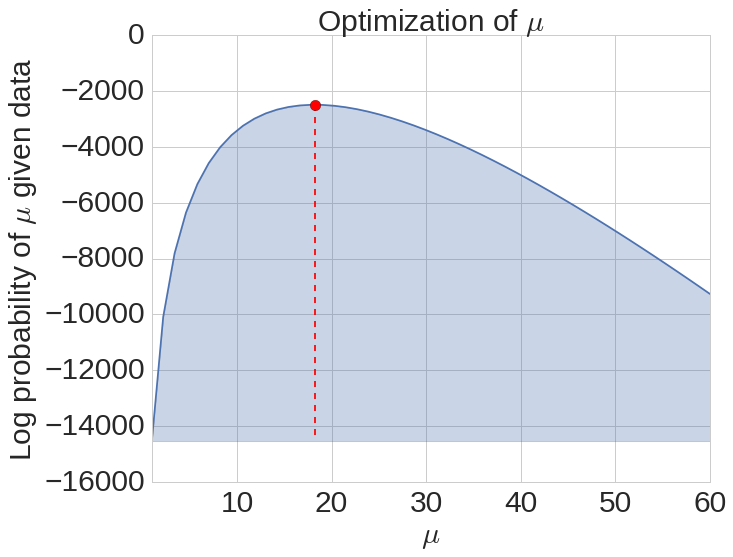

In [26]:
fig = plt.figure(figsize=(10, 8))
plt.plot(x, [poisson_logprob(yobs, i, sign=1) for i in x])
plt.fill_between(x, [poisson_logprob(yobs, i, sign=1) for i in x], ymin, alpha=0.3)

plt.title('Optimization of $\mu$')
plt.xlabel('$\mu$')
plt.ylabel('Log probability of $\mu$ given data')
plt.vlines(freq_results['x'], ymax, ymin, colors='red', linestyles='dashed')
plt.scatter(freq_results['x'], ymax, s=110, c='red', zorder=3)
#plt.ylim(ymin=ymin, ymax=ymax)
plt.xlim(xmin=1, xmax=60);

Plot out the Poisson distribution given the $\mu_{ML}$

In [27]:
x_range = 60
x = range(x_range)

In [28]:
mu_ML = np.int(freq_results['x'])

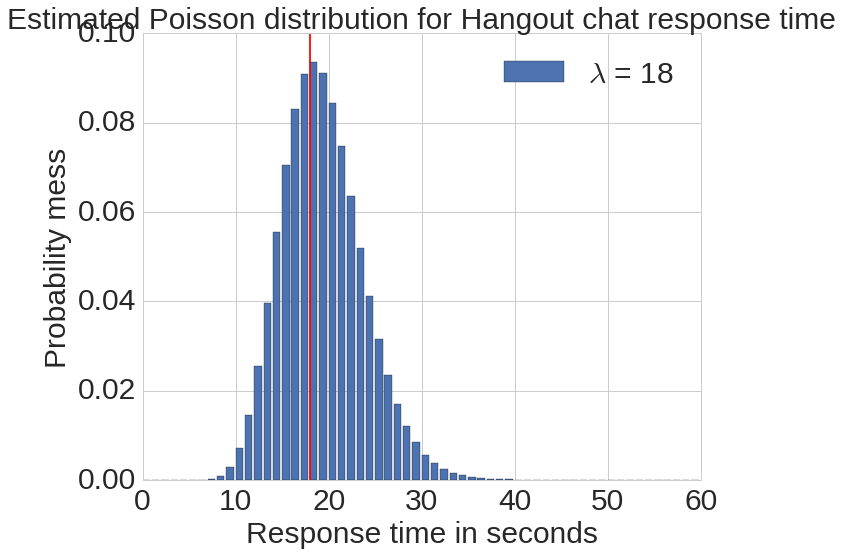

In [29]:
fig = plt.figure(figsize=(10, 8))
ax = plt.subplot(111)
for n in x:
    plt.bar(n, stats.poisson.pmf(mu_ML, n))

ax.set_xlabel('Response time in seconds')
ax.set_ylabel('Probability mess')
ax.set_xlim(0, 60)
ax.set_ylim(0, 0.1)
ax.set_title('Estimated Poisson distribution for Hangout chat response time')
plt.legend(['$\lambda$ = %s' % mu_ML]);
plt.vlines(mu_ML, 0, 0.1, colors = 'r');

The above Poisson model and estimated value of μ suggest that there is minimal chance of an observation less than 10 or greater than 30. The vast majority of the probability mass is between 10 and 30. However, we know this is not reflected in the data that we observed - which has observed values between 0 and 60 (according to histogram of time_delay_seconds attribute).

# Bayesian method of estimating $\mu$

In [ ]:
with pm.Model() as model:
    mu = pm.Uniform('mu', lower=0, upper=60)
    likelihood = pm.Poisson('likelihood', mu=mu, observed=data['time_delay_seconds'].values)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(200000, step, start=start, progressbar=True)

Optimization terminated successfully.
         Current function value: 2487.323198
         Iterations: 6
         Function evaluations: 9
         Gradient evaluations: 9


 39%|███▉      | 78361/200000 [00:15<00:23, 5270.11it/s]

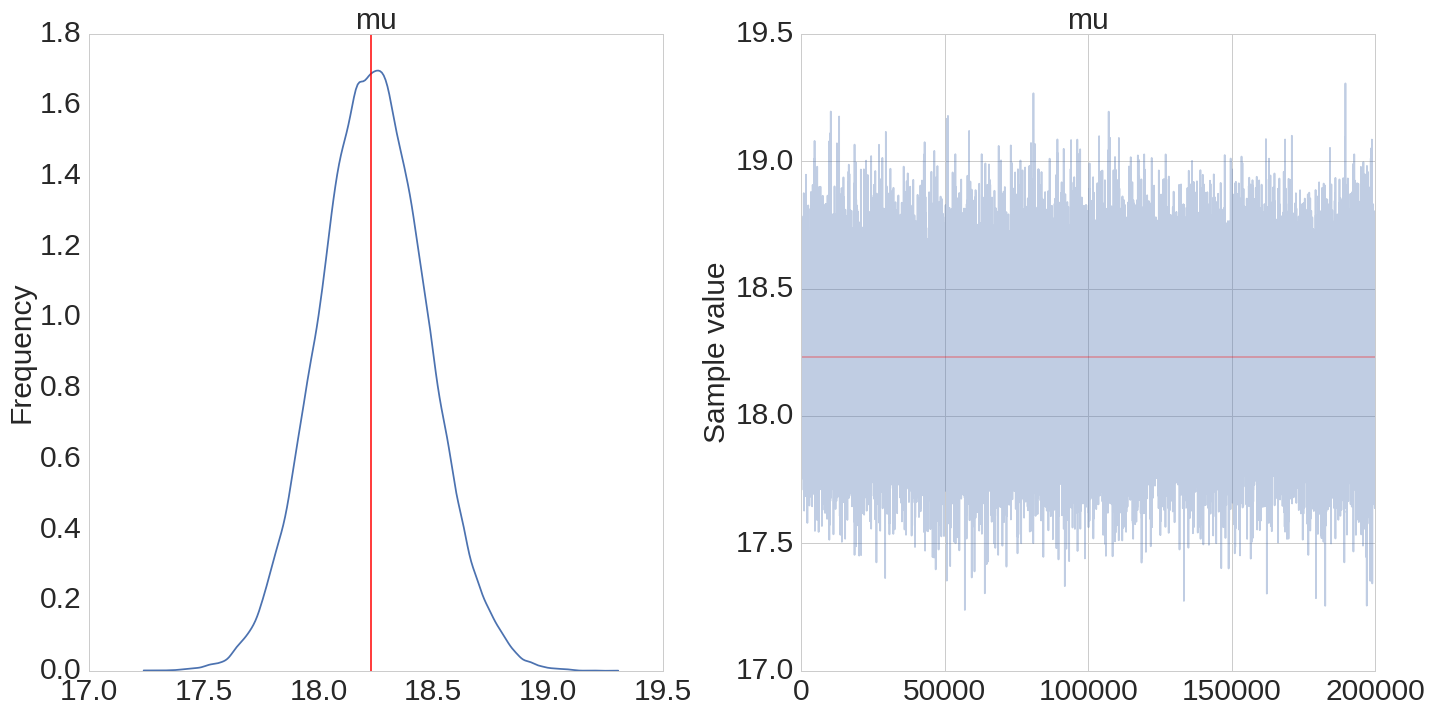

In [53]:
pm.traceplot(trace, varnames=['mu'], lines={'mu':freq_results['x']}, figsize=(20,10));

In the code, we set the initialization (start) as result from MAP() -- maximum a posterior estimator. By setting the starting point as the result from MAP, it helps MCMC sampler find a good place from which to start sampling. Conceptually, it will start the MH in an area of high likelihood. 

# Model convergence

## Trace
Just because the above model estimated a value for $\mu$, doesn't mean the model estimated a good value given the data. There are some recommended checks that you can make. Firstly, look at the trace output. You should see the trace jumping around and generally looking like a hairy caterpillar. If you see the trace snake up and down or appear to be stuck in any one location - it is a sign that you have convergence issues and the estimations from the MCMC sampler cannot be trusted.
## Autocorrelation plot
The second test you can perform is the autocorrelation test (see below plot). It is a measure of correlation between successive samples in the MCMC sampling chain. When samples have low correlation with each other, they are adding more "information" to the estimate of your parameter value than samples that are highly correlated.
Visually, you are looking for an autocorrelation plot that tapers off to zero relatively quickly and then oscilates above and below zero correlation. If your autocorrelation plot does not taper off - it is generally a sign of poor mixing and you should revisit your model selection (eg. likelihood) and sampling methods (eg. Metropolis).

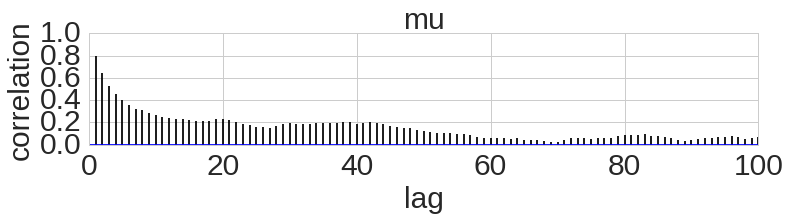

In [54]:
pm.autocorrplot(trace[:2000], varnames=['mu']);

# Section 3. Model checking

The posterior predictive check requires one to generate new data from the predicted model. What does that mean? Well, we have estimated 200,000 credible values of $\mu$ for the Poisson distribution. That means we can construct 200,000 Poisson distributions with these values and then randomly sample from these distributions. This is formally represented as:

$$p(\tilde{y}|y) = \int p(\tilde{y}|\theta) f(\theta|y) d\theta$$

Conceptually, if the model is a good fit for the underlying data - then the generated data should resemble the original observed data. PyMC provides a convenient way to sample from the fitted model. You may have noticed a new line in the above model specification: 

`y_pred = pm.Poisson('y_pred', mu=mu)`

In [35]:
with pm.Model() as model:
    mu = pm.Uniform('mu', lower = 0, upper = 60)
    yest  = pm.Poisson('yest', mu = mu, observed = data['time_delay_seconds'].values)
    ypred = pm.Poisson('ypred', mu = mu)
    
    start = pm.find_MAP()
    step  = pm.Metropolis()
    trace = pm.sample(200000, step, start=start, progressbar=True)

Optimization terminated successfully.
         Current function value: 2493.106610
         Iterations: 6
         Function evaluations: 9
         Gradient evaluations: 9


100%|██████████| 200000/200000 [01:22<00:00, 2436.16it/s]


In [34]:
x_num   = 60
x_range = range(x_num)

In [37]:
# define a burn-in 
burnin = 50000

# retrieve traces for ypred
ypred = trace[burnin:].get_values('ypred')

# retrieve traces for mu
mu = trace[burnin:].get_values('mu')

Plot the predicted output $\hat{y}$ versus really observation y 

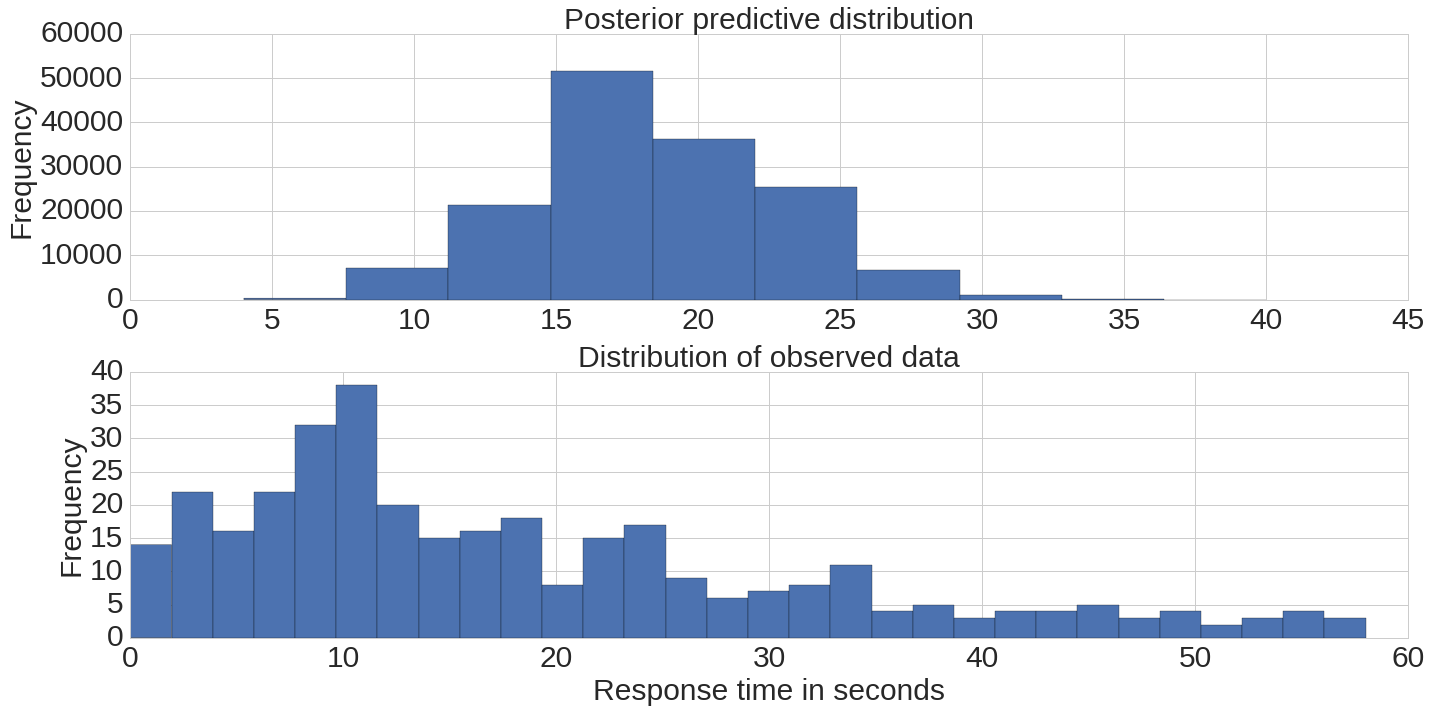

In [61]:
fig = plt.figure(figsize=(20, 10))

ax1 = plt.subplot(211)
ax1.hist(ypred);
ax1.set_ylabel('Frequency')
ax1.set_title('Posterior predictive distribution')

ax2 = plt.subplot(212)
ax2.hist(data['time_delay_seconds'], bins = 30)
ax2.set_xlabel('Response time in seconds')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of observed data')

plt.tight_layout()

Ideally, the posterior predictive distribution to somewhat resemble the distribution of the observed data. Intuitively, if we have correctly estimated the parameters of the model, then we should be able to sample similar data from that model. Clearly this is not the case.
Perhaps the Poisson distribution is not suitable for this data. One alternative option we have is the Negative Binomial distribution. This has very similar characteristics to the Poisson distribution except that it has two parameters ($\mu$ and $\alpha$) which enables it to vary its variance independently of its mean. Recall that the Poisson distribution has one parameter ($\mu$) that represents both its mean and its variance.

In [63]:
?stats.nbinom.pmf

In [64]:
a = [2, 4]
mu = [15, 40]

In [65]:
def get_n(mu, alpha):
    return 1/alpha * mu

In [67]:
def get_p(mu, alpha):
    return get_n(mu, alpha) / (get_n(mu, alpha) + mu)

In [66]:
get_n(mu[0], a[0])

7.5

In [68]:
get_p(mu[0], a[0])

0.3333333333333333